<left>

<img src="https://github.com/alfonso-santos/master-bilbao/blob/main/imgs/logo.PNG?raw=true"  alt="drawing" width="15%"/>

</left>

# Análisis descriptivo de los datos de un activo

Antes de analizar los datos de una cartera de activos, vamos a ver cómo se analizan los datos de un solo activo. Para ello vamos a:

- Descarga y visualización de un activo

- Comprender las limitaciones de trabajar directamente con precios

- Binomio rentabilidad-riesgo

In [133]:
# !pip install mplfinance
# !pip install plotly
# !pip install statsmodels
# !pip install missingno
#!pip install openpyxl

In [134]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
import warnings

import yfinance as yf

import statsmodels.api as sm

# print(plt.style.available) #list of available styles
plt.style.use("ggplot")

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Descarga y visualización de activos

Primero, descargamos los datos y nos quedamos con el valor de `Adj Close`

In [135]:
activos = ["AAPL", "MSFT", "AMZN", "GOOG", "TSLA", "NVDA", "ADBE", "NFLX", 'SOLV']

start_date = "1990-01-01"
end_date = "2021-01-01"
precios = yf.download(
    activos,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    multi_level_index=True,
)['Adj Close']

[*********************100%***********************]  9 of 9 completed

1 Failed download:
['SOLV']: YFPricesMissingError('possibly delisted; no price data found  (1d 1990-01-01 -> 2021-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 631170000, endDate = 1609477200")')


Mostramos información sobre la estructura del DataFrame: tipos de datos, índice, columnas.

In [136]:
precios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7812 entries, 1990-01-02 to 2020-12-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    7812 non-null   float64
 1   ADBE    7812 non-null   float64
 2   AMZN    5948 non-null   float64
 3   GOOG    4122 non-null   float64
 4   MSFT    7812 non-null   float64
 5   NFLX    4686 non-null   float64
 6   NVDA    5523 non-null   float64
 7   SOLV    0 non-null      float64
 8   TSLA    2647 non-null   float64
dtypes: float64(9)
memory usage: 610.3 KB


Vamos a limpiar los datos eliminando los valores `NaN`

<Axes: >

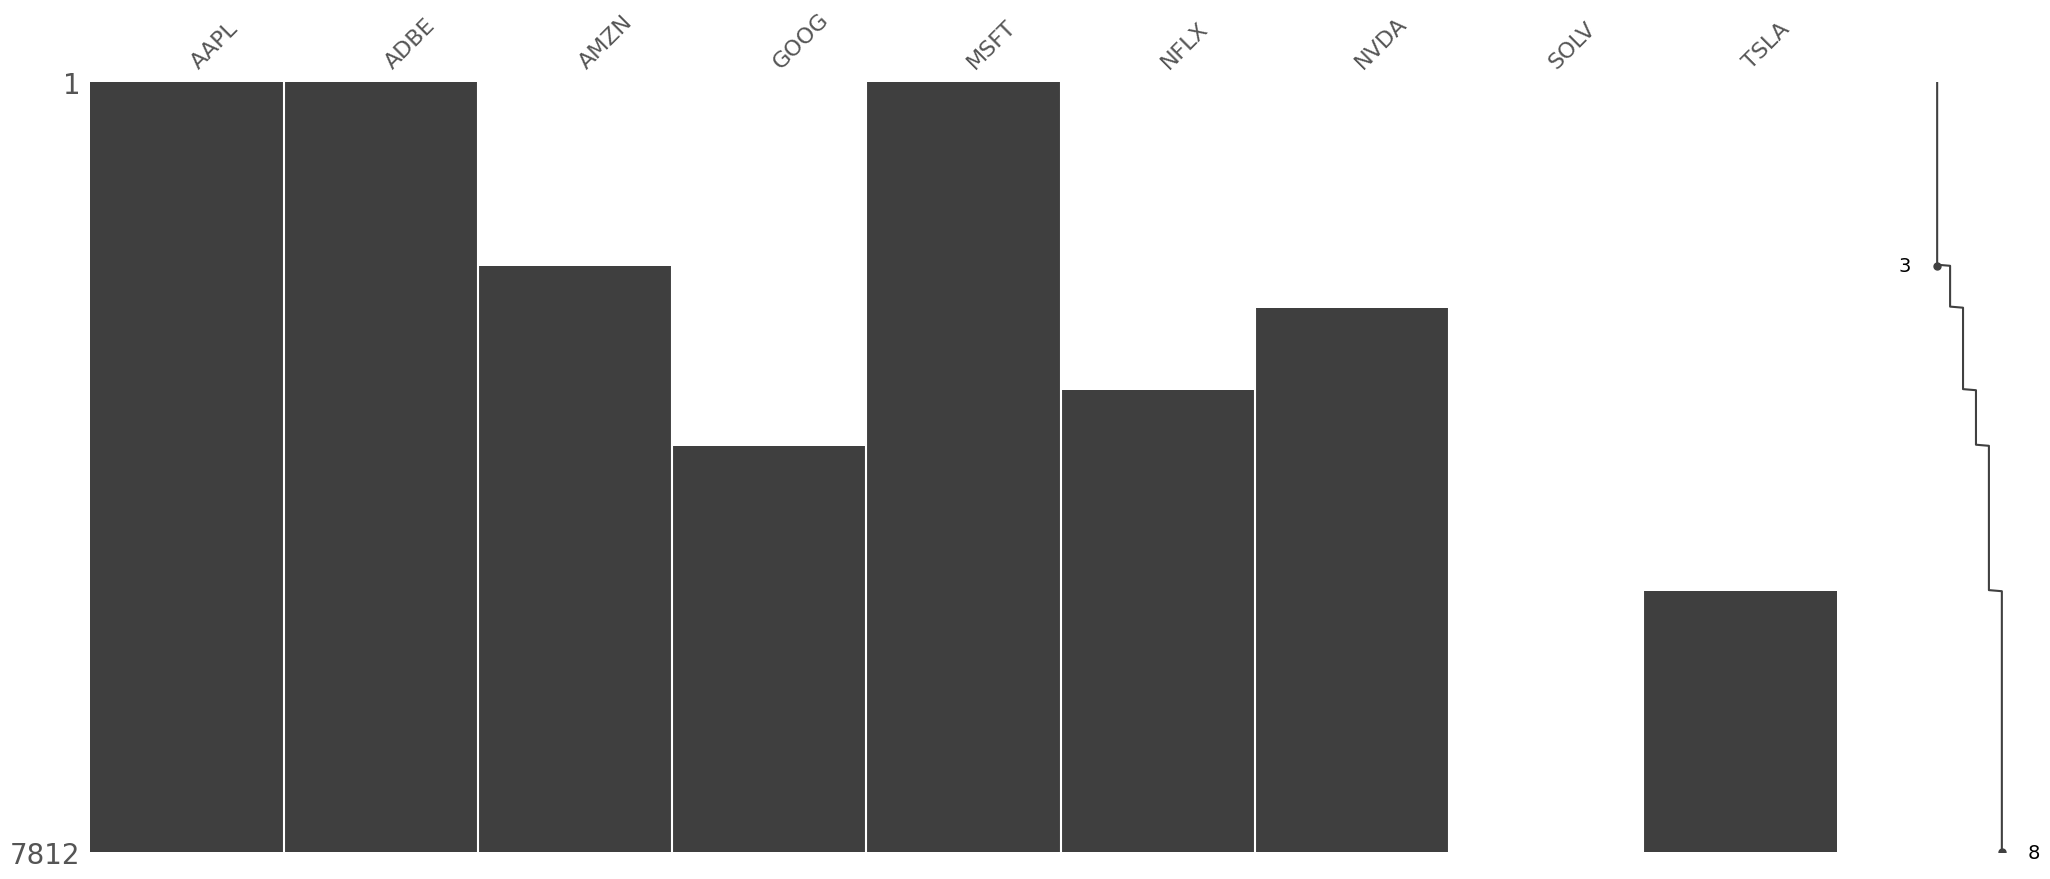

In [137]:
import missingno as msno

msno.matrix(precios)

Primero eliminamos la columna `axis=1` que tiene **todos** los valores `NaN` 

<Axes: >

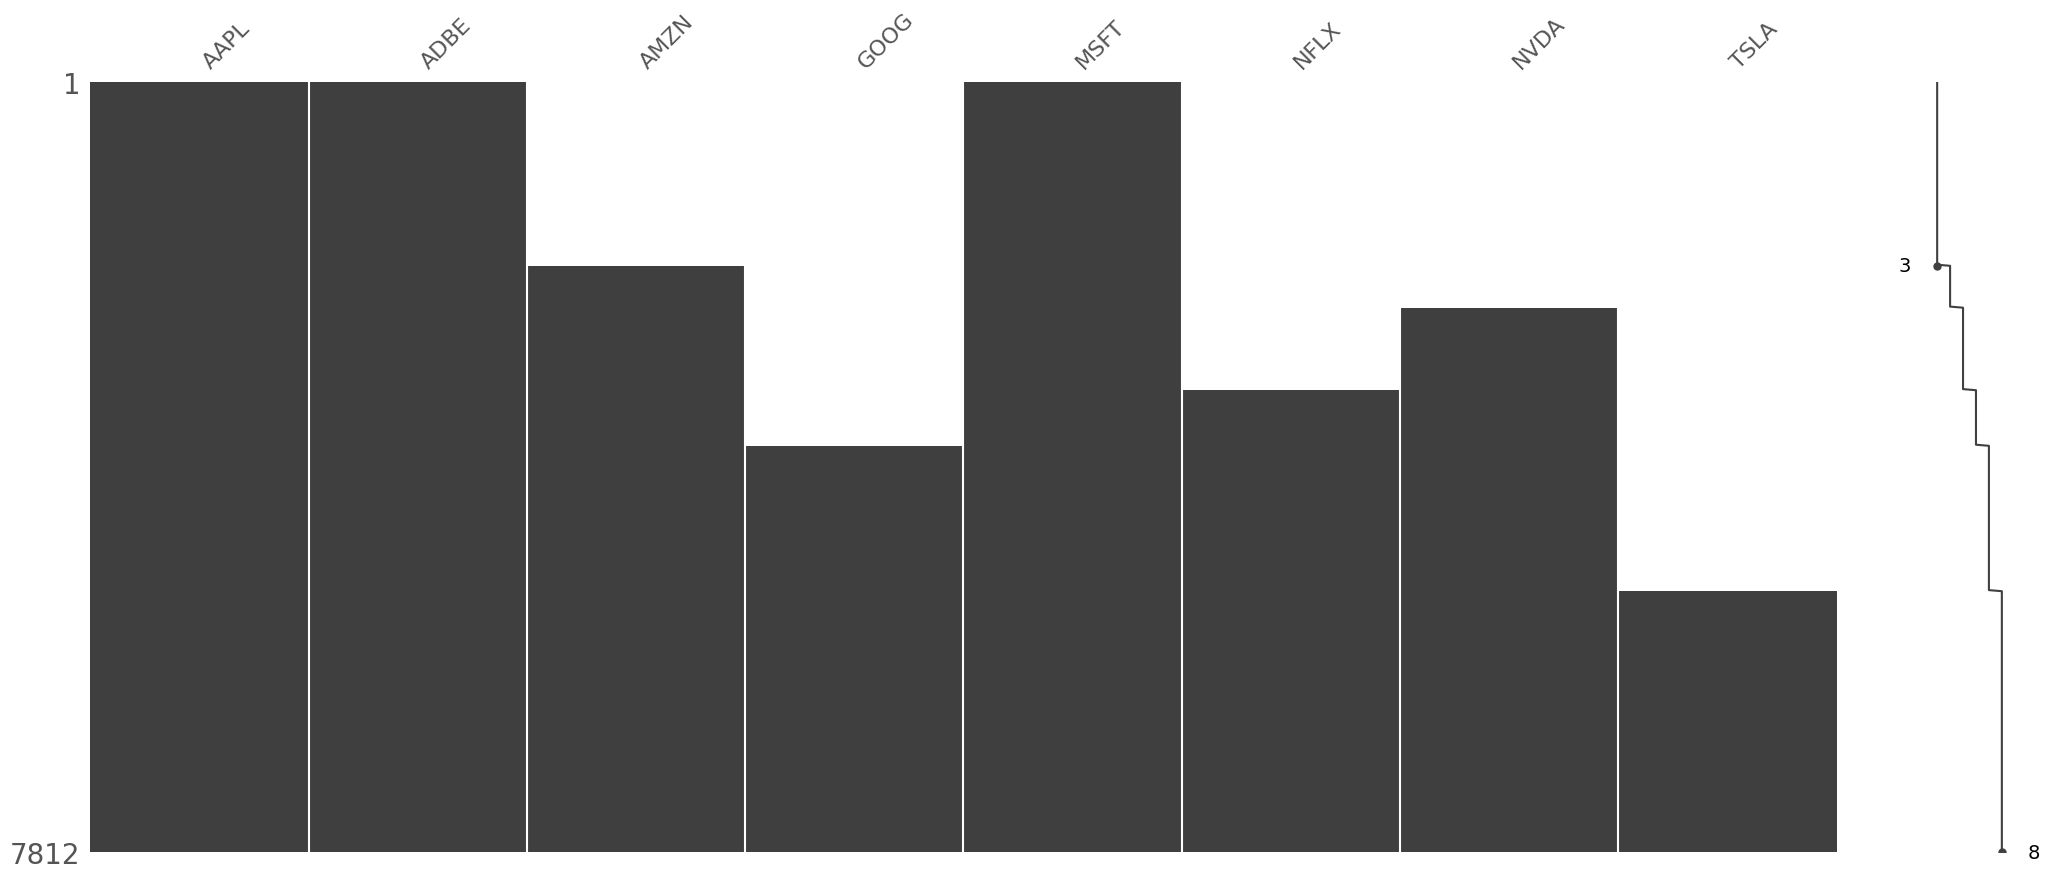

In [138]:
precios = precios.dropna(axis=1,how='all')

msno.matrix(precios)

y luego eliminamos las filas `axis=0` que tienen **algún** valor `NaN`

<Axes: >

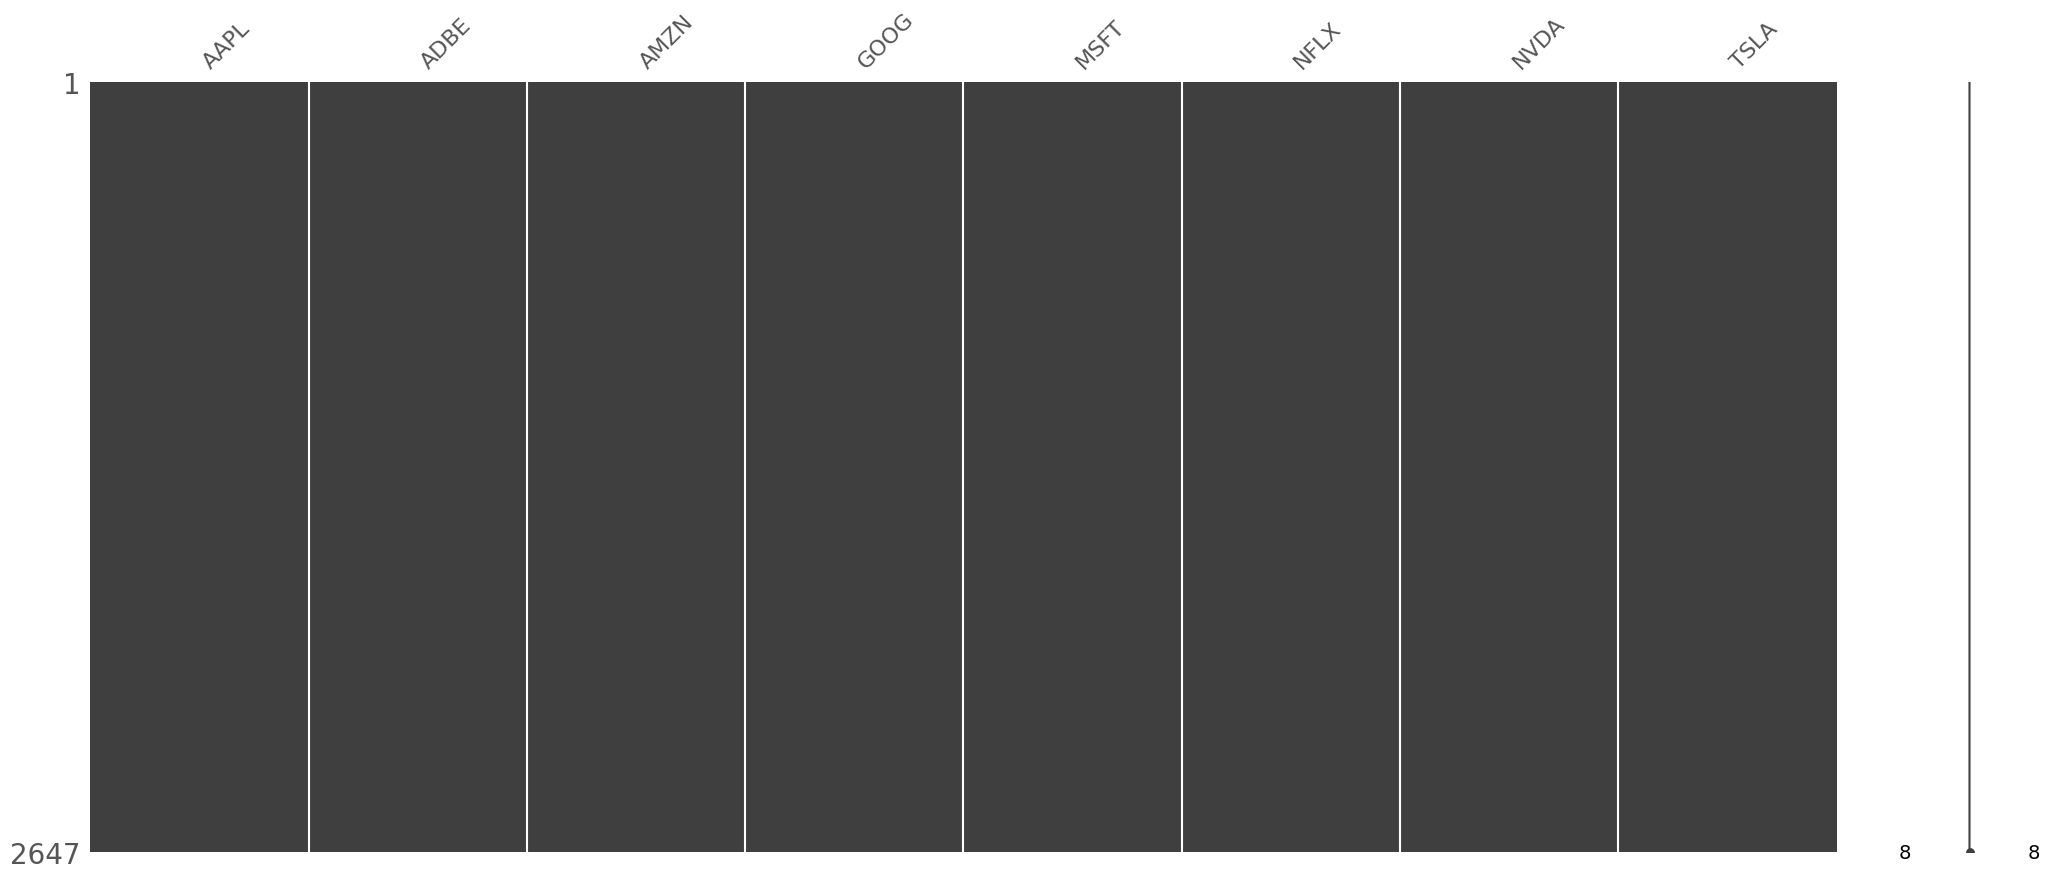

In [139]:
precios = precios.dropna(axis=0,how='any')

msno.matrix(precios)

Mostramos datos estadísticos sobre cada una de las columnas numéricas.

In [140]:
precios.describe()

Ticker,AAPL,ADBE,AMZN,GOOG,MSFT,NFLX,NVDA,TSLA
count,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000,2647.000000
mean,32.497320,137.502992,44.653303,36.891593,64.333109,152.062016,2.584587,20.282475
std,24.446165,123.430343,40.986284,19.579383,51.277579,147.453365,3.183769,31.172472
min,7.220356,22.690001,5.430500,10.809840,17.447615,7.685714,0.203574,1.053333
25%,16.199914,38.625000,13.048750,19.368197,24.926043,33.452858,0.355223,2.491000
50%,25.030045,83.400002,26.658001,32.404518,41.634888,94.410004,0.588715,14.815333
75%,41.104513,226.380005,78.617496,53.302040,90.703350,285.789993,4.328607,20.249001
max,133.516190,533.799988,176.572495,90.968628,222.885452,556.549988,14.519509,235.223328


Ahora los dibujamos

<Axes: xlabel='Date'>

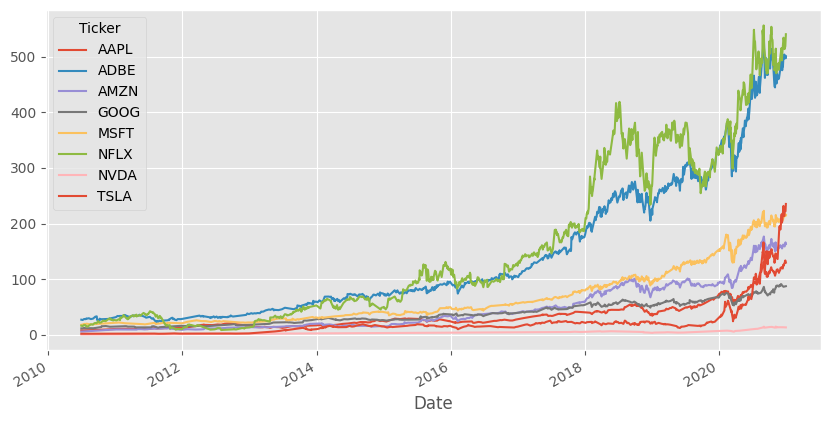

In [141]:
precios.plot(figsize=(10, 5))

<Axes: xlabel='Date'>

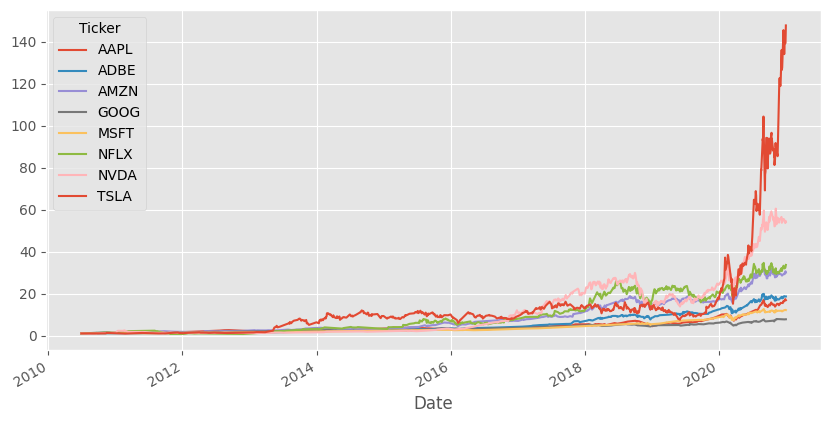

In [142]:
indice_precios = precios/precios.iloc[0, :]

indice_precios.plot(figsize=(10, 5))

___________________________________________________________________________________________________________________________________________

### EJERCICIO

Bájate los precios de cierre ajustados entre 2010 y 2020 de los cuatro activos del ejercicio anterior, límpialos y visualizalos.

In [ ]:
#TO DO

______________________________________________________________________________________

## 1.2 Precios vs Retornos

En el ámbito financiero, no suele ser común trabajar directamente con los precios de los activos, sino que trabajamos con los **retornos** de los precios. Existen dos formas de calcular los retornos a partir de los precios de un activo:

**Retornos aritméticos:**

$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$$

donde $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

**Retornos logarítmicos:**

$$r_t = ln(\frac{P_t}{P_{t-1}}) = ln(P_t) - ln(P_{t-1})$$

donde, como antes, $P_t$ y $P_{t-1}$ representan los precios de cierre en los instantes de tiempo $t$ y $t-1$, respectivamente.

En ambas situaciones, estamos calculando la variación de los precios entre dos instantes de tiempo consecutivos $t$ y $t-1$.


Además, hay una serie de razones por las que es más ventajoso trabajar con retornos:

* **Normalización de datos**: Los retornos permiten normalizar los datos y eliminar la escala absoluta de los precios. Esto facilita la comparación entre diferentes activos financieros, especialmente aquellos con precios muy diferentes.
* **Facilita el análisis estadístico**: Al trabajar con retornos, ``se asume`` que las **rentabilidades son estacionarias débiles** y tienen propiedades estadísticas más estables que los precios absolutos. Esto facilita el uso de herramientas estadísticas y modelos matemáticos en el análisis financiero.
    * Serie estacionaria débil: la media y la varianza de la serie permanecen constantes, y la covarianza entre dos puntos temporales cualesquiera depende únicamente de la diferencia de tiempo entre ellos, en lugar del momento real en el que se realizan las observaciones. 
* **Gestión de riesgos**: En el ámbito de la gestión de riesgos, los retornos son cruciales. Los inversores y gestores de fondos suelen evaluar el riesgo en términos de variaciones en los retornos más que en los cambios absolutos en los precios.
* **Elimina tendencias a largo plazo**: Al trabajar con retornos, se elimina la tendencia de la serie.
* **Simplicidad en cálculos**: En muchos casos, los cálculos de retornos son más simples que los de precios, especialmente cuando se trata de comparar activos a lo largo del tiempo.

Por otro lado, al hacer estudios estadísticos, se utilizan siempre **retornos logarítmicos**:
* Los logaritmos de los precios siguen una distribución normal, esto es, los precios siguen una distribución log-normal.
* Cuando la variación en precio es pequeña, los retornos logarítmicos son muy similares a los retornos aritméticos.
* $log(\frac{p_d}{p_{d-1}})=log(p_d)-log(p_{d-1})$
* La suma (resta) es numéricamente más estable que la multiplicación (división) cuando los números son muy pequeños.


Ref.: https://quantivity.wordpress.com/2011/02/21/why-log-returns/

In [143]:
retornos = np.log(precios).diff().dropna()

<Axes: xlabel='Date'>

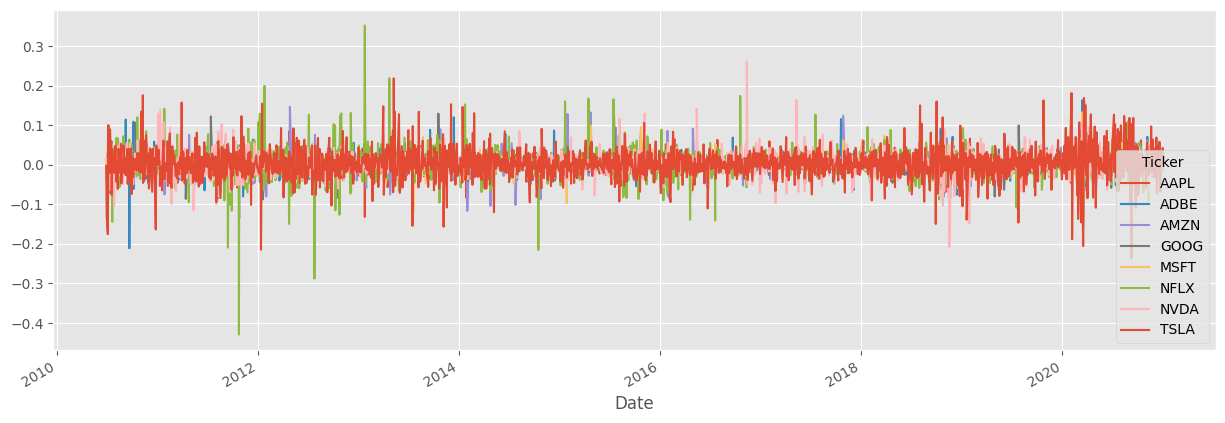

In [165]:
retornos.plot(figsize=(15, 5))

## 1.3 Binomio rentabilidad-riesgo

Pintemos los retornos para ver su evolución temporal:

In [166]:
ret_aapl = retornos["AAPL"]

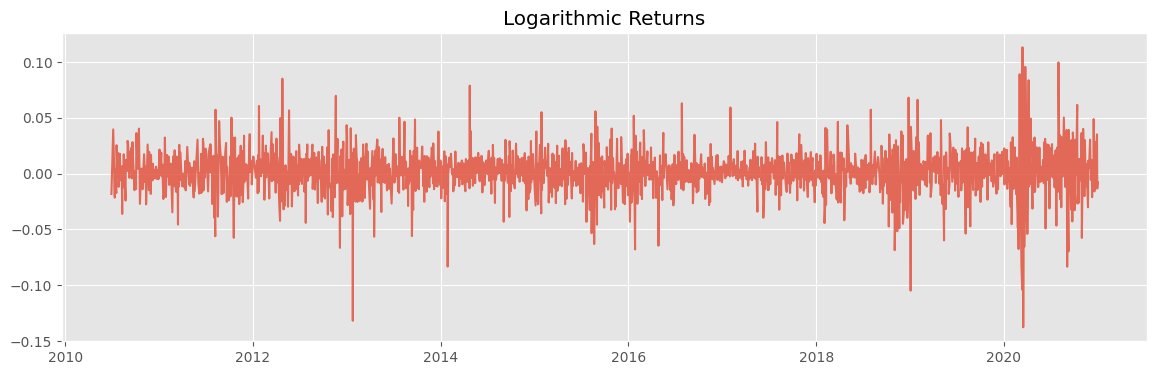

In [167]:
plt.figure(figsize=(14, 4))
plt.plot(ret_aapl, alpha=0.8)
plt.title("Logarithmic Returns", c="black")
plt.show()

Veamos ahora su distribución:

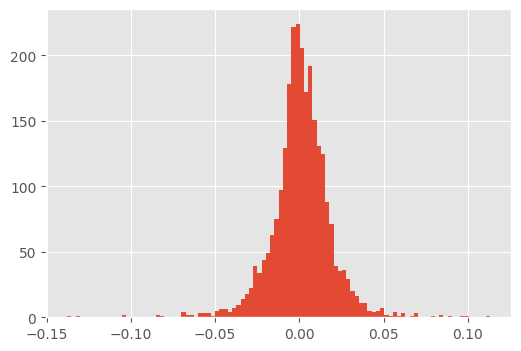

In [147]:
plt.figure(figsize=(6, 4))
plt.hist(ret_aapl, bins=100)
plt.show()

Viendo la figura, aparentemente sigue una distribución Normal (Gaussiana). Entonces, podemos caracterizar los datos mediante su media y su desviación estándar:

1. Se calcula la rentabilidad media de los retornos:

$$\bar{r} = \frac{1}{n} \sum_{i=1}^n r_i$$

2. Se calcula la varianza de los retornos:

$$\sigma^2 = \frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2$$

3. Se calcula la desviación típica de los retornos:

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2}$$

La rentabilidad, varianza y desviación típica **siempre se expresan en términos anuales**:

- Si los datos son **diarios**, consideramos que hay **252 días al año** de negociación.
- Si los datos son **mensuales**, consideramos que hay **12 meses al año**.

In [168]:
print(" Rentabilidad media: {:.4f}".format(ret_aapl.mean() * 252))
print(" Varianza: {:.4f}".format(ret_aapl.var() * 252))
print(" Desviación estándar: {:.4f}".format(np.sqrt(252) * ret_aapl.std()))

 Rentabilidad media: 0.2688
 Varianza: 0.0793
 Desviación estándar: 0.2817


Si suponemos que los retornos siguen una **distribución normal**, los representamos por el **binomio rentabilidad-riesgo**:

- La **rentabilidad** se mide como la media de los retornos.
    
- El **riesgo** se mide a través de la volatilidad, que es la desviación estándar de los rendimientos.

__________________________________________________________________________

### EJERCICIO

Empleando los datos de los 4 activos del ejercicio anterior, calcula la rentabilidad anual media, la varianza anual y la desviación típica anual de los retornos de cada activo. Representa además la distribución de los retornos diarios de uno de ellos.

In [164]:
#TO-DO


---

## 1.4 Asimetría y Curtosis

### Asimetría o skewness

El tercer momento de una función de distribución nos mide su nivel de asimetría. Así:

* Una asimetría positiva indica que la acción tiene una mayor probabilidad por encima de la media.

* Una asimetría negativa indica que la acción tiene una mayor probabilidad por debajo de la media.

* Una asimetría neutra indica que la acción tiene una probabilidad equilibrada a ambos lados de la media.


<center>

<img src="https://github.com/alfonso-santos/master-bilbao/blob/main/imgs/skewness.PNG?raw=true"  alt="drawing" width="15%"/>

</center>

Analicemos la asimetría de los retornos de los activos que tenemos. Si los retornos siguieran una distribución normal, la asimetría debería ser 0.

In [ ]:
df_skew = ret_close_df.skew()


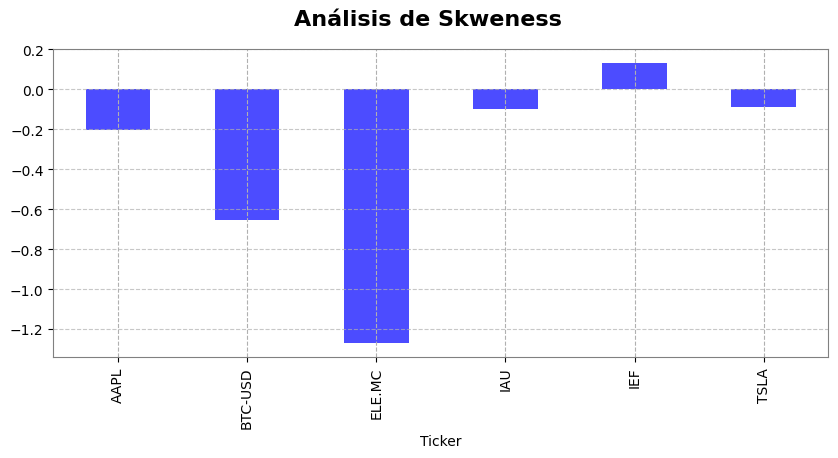

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
# Plot annual means
df_skew.plot(kind='bar', ax=ax, color='blue', alpha=0.7)

ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir un título general a la figura
plt.suptitle("Análisis de Skweness", fontsize=16)  # Título general

plt.show()

Podemos observar que, mayoritariamente, predominan los activos con asimetrías negativas. Eso significa que, por lo general, la cola izquierda es más pesada que la derecha. Es decir, hay más probabilidad de que ocurran eventos negativos extremos que positivos extremos.

Veamos qué sucede con `Endesa` (ELE.MC), que tiene una asimetría negativa elevada:

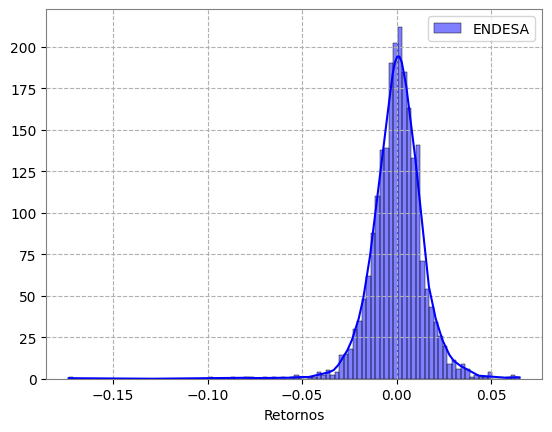

In [ ]:
sns.histplot(
    data=ret_close_df,
    x="ELE.MC",
    bins=100,
    color="blue",
    kde=True,
    alpha=0.5,
    label="ENDESA",
)


plt.xlabel("Retornos")


plt.ylabel("", color="blue")


plt.legend()


plt.show()

In [ ]:
print("Asimetría de Endesa:", np.around(ret_close_df["ELE.MC"].skew(), decimals=3))

Asimetría de Endesa: -1.27


Veamos qué sucede con `Tesla` (TSLA), que tiene una asimetría neutra:

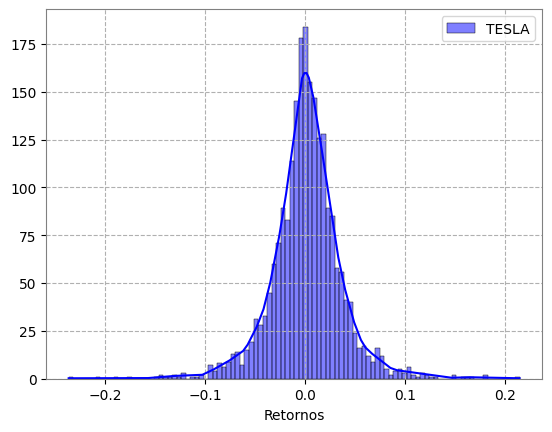

In [ ]:
sns.histplot(
    data=ret_close_df,
    x="TSLA",
    bins=100,
    color="blue",
    kde=True,
    alpha=0.5,
    label="TESLA",
)


plt.xlabel("Retornos")


plt.ylabel("", color="blue")


plt.legend()


plt.show()

In [ ]:
print("Asimetría de Tesla:", np.around(ret_close_df["TSLA"].skew(), decimals=3))

Asimetría de Tesla: -0.087


<hr>

### Curtosis o kurtosis

La curtosis, en estadística, es una medida que describe la forma de la distribución de los datos, específicamente cuán "pesadas" o "ligeras" son las colas de la distribución en comparación con una distribución normal (campana de Gauss). Aquí te ofrezco una forma intuitiva de explicarla:
 
Imagina que tienes dos montañas hechas de arena. La primera montaña es amplia y baja, extendiéndose suavemente hacia los lados. La segunda montaña es más alta y puntiaguda, con lados más empinados. Ambas montañas pueden tener la misma cantidad de arena, pero están distribuidas de manera diferente.
 
- **Curtosis baja (Platicúrtica)**: Es como la primera montaña, más plana y extendida. Esto significa que los datos están más dispersos, hay menos concentración de datos cerca del promedio y las colas son más "ligeras". En esta distribución, los eventos extremos (muy lejos del promedio) son menos comunes.
 
- **Curtosis alta (Leptocúrtica)**: Es como la segunda montaña, más alta y estrecha. Aquí, los datos están más concentrados cerca del promedio y las colas son más "pesadas". Esto implica que hay una mayor probabilidad de encontrar valores extremos.
 
- **Curtosis normal (Mesocúrtica)**: Es similar a la distribución normal, ni muy plana ni muy puntiaguda. Representa un equilibrio entre la dispersión de los datos y la frecuencia de eventos extremos.
 
En resumen, la curtosis te dice si los eventos extremos son más o menos comunes en tu conjunto de datos en comparación con una distribución normal. Es importante recordar que la curtosis no mide los picos en sí, sino la "pesadez" de las colas de la distribución.

La interpretación de la curtosis de los retornos de una acción es la siguiente:

* Una curtosis **igual a 0** indica que os retornos siguen una **distribución normal**.

* Una curtosis **mayor que 0** indica que la acción tiene una **mayor probabilidad de generar retornos extremos**, ya sean positivos o negativos.

* Una curtosis **menor que 0** indica que la acción tiene una **menor probabilidad de generar retornos extremos**.

In [ ]:
df_curto = ret_close_df.kurtosis()


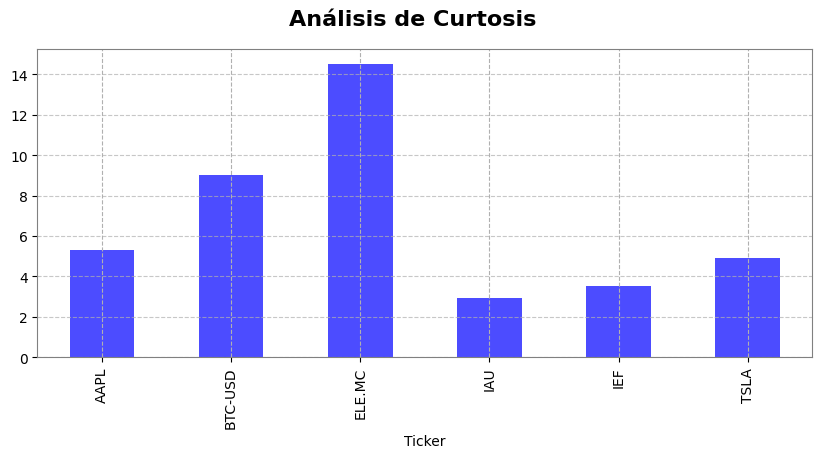

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
# Plot annual means
df_curto.plot(kind='bar', ax=ax, color='blue', alpha=0.7)

ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir un título general a la figura
plt.suptitle("Análisis de Curtosis", fontsize=16)  # Título general

plt.show()

Veamos el impacto de la curtosis en la distribución de los retornos.

Recordad que valores altos de curtosis indican probabilidad de retornos extremos, por lo general grandes pérdidas.

Vamos a graficar la distribución de los retornos de un activo con un valor alto de curtosis y otro con un valor bajo de curtosis.

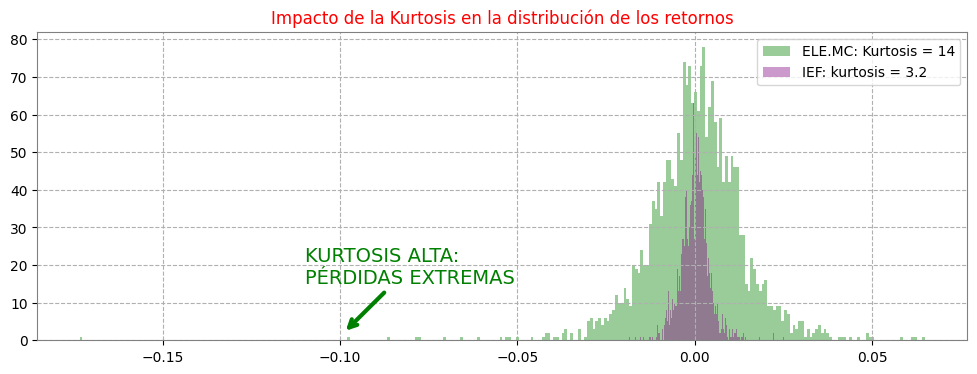

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

plt.hist(
    ret_close_df["ELE.MC"],
    bins=300,
    color="green",
    alpha=0.4,
    label="ELE.MC: Kurtosis = 14",
)
# plt.hist(ret_close_df_corr['ORCL'], bins=300, color='green', alpha=0.4, label='ORCL')
plt.hist(
    ret_close_df["IEF"],
    bins=300,
    color="purple",
    alpha=0.4,
    label="IEF: kurtosis = 3.2",
)

# Dibuja una flecha utilizando annotate
ax.annotate(
    "KURTOSIS ALTA:\nPÉRDIDAS EXTREMAS",
    xy=(-0.099, 2),
    xytext=(-0.11, 15),
    arrowprops=dict(arrowstyle="->", linewidth=3, color="green"),
    fontsize=14,
    color="green",
)

plt.title("Impacto de la Kurtosis en la distribución de los retornos")
plt.legend()
plt.show()

## 1.5 Conclusiones

1- Hemos aprendido a estimar rentabilidades de un activo, que serán las que utilizaremos para su análisis descriptivo en lugar de los precios.


2- Hemos supuesto que las rentabilidades se comportan como una distribución Normal tipificada por su media y varianza.


3- La media es una medida de lo que esperamos obtener de rentabilidad y la desviación típica es una aproximación al riesgo que asumimos.


4- Se ha comprobado que en realidad, las funciones de distribución de los retornos de los activos no se comportan exactamente igual a una Normal. Generalmente tenemos colas pesadas con incidencias significativas en el resultado de nuestras inversiones.


5- Hemos estimado el tercer y cuarto momento (asimetría y curtosis) para tratar de cuantificar la importancia de las colas pesadas de la distribución.



____________________________________________________

### EJERCICIO

Empleando los datos de los 4 activos del ejercicio anterior, calcula y grafica la skweness y curtosis de los retornos de cada activo. 